# Lightning Integration Basics

The following notebook is equivalent to /parametric_programming/Part_1_basics.ipynb, but now showcasing the use of **PyTorch-Lightning** to simplify the user workflow. 

We will demonstrate the capability of learning to optimize (L2O)
for solving [parametric nonlinear programming problem (pNLP)](https://en.wikipedia.org/wiki/Parametric_programming) defined as:

$$
\begin{align}
&\text{minimize } &&  f(x, \theta) \\
&\text{subject to} && g(x, \theta) \le 0
\end{align}
$$

with  parameters $\theta$ and decision variables $x$.

In L2O train a neural network mapping problem parameters onto the primal decision variables $x = \pi(\theta)$ by using gradients of the optimizaiton problem to minimize the objective function and satisfy the constraints.

### References
[1] [F. Fioretto, et al., Predicting AC Optimal Power Flows: Combining Deep Learning and Lagrangian Dual Methods, 2019](https://arxiv.org/abs/1909.10461)  
[2] [S. Gould, et al., Deep Declarative Networks: A New Hope, 2020](https://arxiv.org/abs/1909.04866)  
[3] [P. Donti, et al., DC3: A learning method for optimization with hard constraints, 2021](https://arxiv.org/abs/2104.12225)  
[4] [J. Kotary, et al., End-to-End Constrained Optimization Learning: A Survey, 2021](https://arxiv.org/abs/2103.16378)  
[5] [M. Li, et al., Learning to Solve Optimization Problems with Hard Linear Constraints, 2022](https://arxiv.org/abs/2208.10611)  
[6] [R. Sambharya, et al., End-to-End Learning to Warm-Start for Real-Time Quadratic Optimization, 2022](https://arxiv.org/abs/2212.08260)  



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
!pip install lightning 


### Import

(The user might need to install PyTorch Lightning). If so, please run 

```
pip install lightning
```

In [1]:
import torch
import torch.nn as nn
import numpy as np
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import casadi
import time
import lightning.pytorch as pl 


In [2]:
from neuromancer.trainer import Trainer, LitTrainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node


# Problem formulation

In this example we will solve parametric constrained [Rosenbrock problem](https://en.wikipedia.org/wiki/Rosenbrock_function):

$$
\begin{align}
&\text{minimize } &&  (1-x)^2 + a(y-x^2)^2\\
&\text{subject to} && \left(\frac{p}{2}\right)^2 \le x^2 + y^2 \le p^2\\
& && x \ge y
\end{align}
$$

with parameters $p, a$ and decision variables $x, y$.


# Lightning Workflow

The workflow when using Lightning consists of three parts: 

1. Defining a "data_setup_function() -- this function should return 4 values (train, dev, test datasets, and batch size). The datasets should be named Neuromancer DictDatasets. 
2. Defining the Problem -- consisting of Nodes, System, Loss. 
3. Instantiating the PyTorch-Lightning -based Trainer (LitTrainer class)

For this notebook, we assume all operations are done on the CPU. 

### Lightning Dataset

We constructy the dataset by sampling the parametric space.

In [3]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed)
nsim = 5000  # number of datapoints: increase sample density for more robust results

# create dictionaries with sampled datapoints with uniform distribution
a_low, a_high, p_low, p_high = 0.2, 1.2, 0.5, 2.0

We define the **data_setup_function()** below. It randomly sample parameters from a uniform distribution: $0.5\le p\le2.0$;  $0.2\le a\le1.2$. It takes these parameters as inputs and outputs Neuromancer DictDatasets() for train, dev, and test data (or None type otherwise), as well as batch size (such as if we want to minibatch w.r.t time on the DictDatasets) We have hardcoded batch size to be 64 in this case. 

It is important to define both training and dev/validation datasets. Training datasets will be used for the training step; dev datasets will be used for model checkpointing (if desired)

In [4]:

def data_setup_function(nsim, a_low, a_high, p_low, p_high): 

    
    samples_train = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
                    "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
    samples_dev = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
                "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
    samples_test = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
                "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
    # create named dictionary datasets
    train_data = DictDataset(samples_train, name='train')
    dev_data = DictDataset(samples_dev, name='dev')
    test_data = DictDataset(samples_test, name='test')

    batch_size = 64

    # Return the dict datasets in train, dev, test order, followed by batch_size 
    return train_data, dev_data, test_data, batch_size 



We now define the **Problem()**

## Primal Solution Map Architecture

A neural network mapping problem parameters onto primal decision variables:  
$$x = \pi(\theta)$$

In [5]:
# define neural architecture for the trainable solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# wrap neural net into symbolic representation of the solution map via the Node class: sol_map(xi) -> x
sol_map = Node(func, ['a', 'p'], ['x'], name='map')

## Objective and Constraints in NeuroMANCER

In [6]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""

# define decision variables
x1 = variable("x")[:, [0]]
x2 = variable("x")[:, [1]]
# problem parameters sampled in the dataset
p = variable('p')
a = variable('a')

# objective function
f = (1-x1)**2 + a*(x2-x1**2)**2
obj = f.minimize(weight=1.0, name='obj')

# constraints
Q_con = 100.  # constraint penalty weights
con_1 = Q_con*(x1 >= x2)
con_2 = Q_con*((p/2)**2 <= x1**2+x2**2)
con_3 = Q_con*(x1**2+x2**2 <= p**2)
con_1.name = 'c1'
con_2.name = 'c2'
con_3.name = 'c3'

In [7]:
# constrained optimization problem construction
objectives = [obj]
constraints = [con_1, con_2, con_3]
components = [sol_map]

# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)

# Define Lightning Modules and Training

We now instantiate the trainer and data modules as shown below. We will then train our Neuromancer **problem** on this data setup function using the **fit** function. The original problem will already have its weights updated. 

In [9]:
lit_trainer = LitTrainer(epochs=10, accelerator='cpu', patience=3)
lit_trainer.fit(problem, data_setup_function, nsim=nsim,a_low=0.2, a_high=1.2, p_low=0.5, p_high=2.0)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory ./ exists and is not empty.

  | Name    | Type    | Params
------------------------------------
0 | problem | Problem | 19.8 K
------------------------------------
19.8 K    Trainable params
0         Non-trainable params
19.8 K    Total params
0.079     Total estimated model params size (MB)


/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 79/79 [00:00<00:00, 126.64it/s, v_num=15, train_loss_step=0.903]

/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 79/79 [00:01<00:00, 70.31it/s, v_num=15, train_loss_step=0.903, dev_loss=0.815, train_loss_epoch=5.690]

Epoch 0, global step 79: 'dev_loss' reached 0.81470 (best 0.81470), saving model to './epoch=0-step=79.ckpt' as top 1


Epoch 1: 100%|██████████| 79/79 [00:00<00:00, 81.24it/s, v_num=15, train_loss_step=0.528, dev_loss=0.421, train_loss_epoch=0.881] 

Epoch 1, global step 158: 'dev_loss' reached 0.42123 (best 0.42123), saving model to './epoch=1-step=158.ckpt' as top 1


Epoch 2: 100%|██████████| 79/79 [00:00<00:00, 81.72it/s, v_num=15, train_loss_step=0.144, dev_loss=0.111, train_loss_epoch=0.286]  

Epoch 2, global step 237: 'dev_loss' reached 0.11081 (best 0.11081), saving model to './epoch=2-step=237.ckpt' as top 1


Epoch 3: 100%|██████████| 79/79 [00:00<00:00, 87.08it/s, v_num=15, train_loss_step=0.228, dev_loss=0.187, train_loss_epoch=0.171]  

Epoch 3, global step 316: 'dev_loss' was not in top 1


Epoch 4: 100%|██████████| 79/79 [00:00<00:00, 86.42it/s, v_num=15, train_loss_step=0.159, dev_loss=0.105, train_loss_epoch=0.147]  

Epoch 4, global step 395: 'dev_loss' reached 0.10479 (best 0.10479), saving model to './epoch=4-step=395.ckpt' as top 1


Epoch 5: 100%|██████████| 79/79 [00:00<00:00, 88.72it/s, v_num=15, train_loss_step=0.103, dev_loss=0.140, train_loss_epoch=0.128]  

Epoch 5, global step 474: 'dev_loss' was not in top 1


Epoch 6: 100%|██████████| 79/79 [00:00<00:00, 80.26it/s, v_num=15, train_loss_step=0.155, dev_loss=0.104, train_loss_epoch=0.138]  

Epoch 6, global step 553: 'dev_loss' reached 0.10385 (best 0.10385), saving model to './epoch=6-step=553.ckpt' as top 1


Epoch 7: 100%|██████████| 79/79 [00:00<00:00, 83.75it/s, v_num=15, train_loss_step=0.110, dev_loss=0.0644, train_loss_epoch=0.120] 

Epoch 7, global step 632: 'dev_loss' reached 0.06439 (best 0.06439), saving model to './epoch=7-step=632-v1.ckpt' as top 1


Epoch 8: 100%|██████████| 79/79 [00:00<00:00, 79.68it/s, v_num=15, train_loss_step=0.140, dev_loss=0.0949, train_loss_epoch=0.124]  

Epoch 8, global step 711: 'dev_loss' was not in top 1


Epoch 9: 100%|██████████| 79/79 [00:00<00:00, 86.22it/s, v_num=15, train_loss_step=0.142, dev_loss=0.0917, train_loss_epoch=0.146]  

Epoch 9, global step 790: 'dev_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 79/79 [00:00<00:00, 84.98it/s, v_num=15, train_loss_step=0.142, dev_loss=0.0917, train_loss_epoch=0.146]


# Commentary

The idea for PyTorch Lightning integration is to streamline the user experience such that the user can focus solely on the Problem and Data. Lightning emphasizes modularity; the aim here is to easily be able to swap out different problems and/or datasets, akin to running different experimental configurations. For example, we could easily procure different datasets by varying one of the data parameters (such as a_low) and easily fit our Problem to each of these datasets.  

# After Training 

We can use the newly-trained Problem just as in the original version of the notebook: 

## Get pNLP solution from trained neural network

In [12]:
# selected problem parameters
p = 1.0
a = 1.0

In [13]:
# Solution to mpNLP via Neuromancer
datapoint = {'a': torch.tensor([[a]]), 'p': torch.tensor([[p]]),
             'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(x_nm)
print(y_nm)

0.7884852
0.56312114


## Get pNLP solution from CasADi for comparison

[CasADi](https://web.casadi.org/) is an open-source tool for constrained optimization and optimal control that has influenced the development of NeuroMANCER.

In [14]:
# instantiate casadi optimizaiton problem class
def NLP_param(a, p, opti_silent=False):
    opti = casadi.Opti()
    # define variables
    x = opti.variable()
    y = opti.variable()
    p_opti = opti.parameter()
    a_opti = opti.parameter()
    # define objective and constraints
    opti.minimize((1 - x) ** 2 + a_opti * (y - x ** 2) ** 2)
    opti.subject_to(x >= y)
    opti.subject_to((p_opti / 2) ** 2 <= x ** 2 + y ** 2)
    opti.subject_to(x ** 2 + y ** 2 <= p_opti ** 2)
    # select IPOPT solver and solve the NLP
    if opti_silent:
        opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    else:
        opts = {}
    opti.solver('ipopt', opts)
    # set parametric values
    opti.set_value(p_opti, p)
    opti.set_value(a_opti, a)
    return opti, x, y

# construct casadi problem
opti, x, y = NLP_param(a, p)
# solve NLP via casadi
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [15]:
print(f"x = {sol.value(x)}")
print(f"y = {sol.value(y)}")

x = 0.8081695826847699
y = 0.588949838491767


## Compare: NeuroMANCER vs. CasADi

/tmp/ipykernel_373406/1714511162.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg1.collections,
/tmp/ipykernel_373406/1714511162.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg2.collections,
/tmp/ipykernel_373406/1714511162.py:27: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg3.collections,


0.7884852
0.56312114


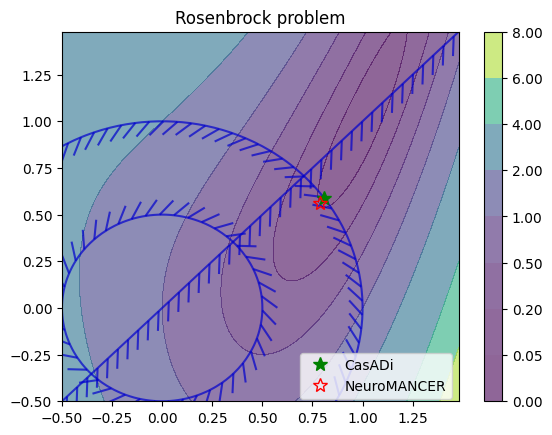

In [16]:
"""
Plots
"""
x1 = np.arange(-0.5, 1.5, 0.02)
y1 = np.arange(-0.5, 1.5, 0.02)
xx, yy = np.meshgrid(x1, y1)

# eval objective and constraints
J = (1 - xx) ** 2 + a * (yy - xx ** 2) ** 2
c1 = xx - yy
c2 = xx ** 2 + yy ** 2 - (p / 2) ** 2
c3 = -(xx ** 2 + yy ** 2) + p ** 2

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(xx, yy, J,
                 levels=[0, 0.05, 0.2, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0],
                 alpha=0.6)
fig.colorbar(cp)
ax.set_title('Rosenbrock problem')
cg1 = ax.contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg1.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg2 = ax.contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg2.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg3 = ax.contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg3.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)

# Solution to mpNLP via Neuromancer
datapoint = {'a': torch.tensor([[a]]), 'p': torch.tensor([[p]]),
             'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(x_nm)
print(y_nm)

# plot optimal solutions CasADi vs Neuromancer
ax.plot(sol.value(x), sol.value(y), 'g*', markersize=10, label='CasADi')
ax.plot(x_nm, y_nm, 'r*', fillstyle='none', markersize=10, label='NeuroMANCER')
plt.legend(bbox_to_anchor=(1.0, 0.15))
plt.show(block=True)